In [1]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import pickle as pkl
import networkx as nx
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter,joint_meas_func
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import dLdp
from utils.regions import CircleExterior
from tracking_log import logger



%load_ext autoreload
%autoreload 2

In [2]:
class DistributedEKF:
    """
        The distributed version of Extended Kalman Filter, used by a single robot to estimate the source location from the information shared by its local teammates via comm.
        
        The major difference of this estimator from the conventional EKF is that the measurement function may be changing in time, so are the dimensions of y_t and p_t, due to 
        the change in the group of local teammates, as a result of changing comm. network topology.
        
        The estimator assumes a constant-velocity source movement model, with the velocity to be the fundamental uncertainty.
    """
    def __init__(self,q_0,R_mag=1,Q_mag=1):
        '''
        q_0 should be a vector, the initial guess of source position.
        
        R_mag,Q_mag should be scalars.
        '''
        
        self.q = q_0 # Mean
        self.qdot = np.zeros(self.q.shape) # Velocity Mean
        
        self.z = np.hstack([self.q,self.qdot]) # The source state
        
        
        self.qdim = len(self.q)
        
        self.P = np.eye(len(self.z)) # Covariance of [q,qdot]. Initialized to be the identity matrix
        
        self.R_mag = R_mag 
        self.Q_mag = Q_mag
    
    def dfdz(self,z):
        n = len(z)//2
        O =np.zeros((n,n))
        I=np.eye(n)
        return np.vstack([np.hstack([I,I]),np.hstack([O,I])])

    def f(self,z):
        """
            The constant velocity model.
        """
        A = self.dfdz(z)
        
        return A.dot(z)
    def update(self,h,dhdz,y,p):
        """
        h is a function handle h(z,p), the measurement function that maps z,p to y.
        dhdz(z,p) is its derivative function handle.
        
        y is the actual measurement value, subject to measurement noise.
        
        p is the positions of the robots.
        """
        A = self.dfdz(self.z)
        C = dhdz(self.z,p)
        R = self.R_mag*np.eye(len(y))
        Q = self.Q_mag*np.eye(len(self.z))
        
        # The Kalman Gain
        K = A.dot(self.P).dot(C.T).dot(    np.linalg.inv(C.dot(self.P).dot(C.T)+R)      )

        # Mean and covariance update
        self.z = self.f(self.z)+K.dot(y-h(self.z,p))
        
        self.P = A.dot(self.P).dot(A.T)+ Q- K.dot(C.dot(self.P).dot(C.T)+R).dot(K.T)
        
    def update_and_estimate_loc(self,h,dhdz,y,p):
        if not np.any(y == np.inf):
            self.update(h,dhdz,y,p)

        return self.z[:len(self.q)]

    
        
        

In [3]:
def fc_comm_network(i,qs,ps):
    """
        Given the iteration number i, source location qs, sensor location ps,
        return the current communication network G.
        
        This variation returns a fully connected network with number of nodes=len(ps),
        without self-loops.
    """
    A = np.ones([len(ps),len(ps)])-np.eye(len(ps))
    return nx.from_numpy_matrix(A,create_using=nx.DiGraph)

In [4]:
def random_switch_netowrk(i,qs,ps,conn_rate=0.5):
    """
        Given the iteration number i, source location qs, sensor location ps,
        return the current communication network G.
        
        This variation returns a random network with number of nodes=len(ps),
        where Aij=1 with probability=conn_rate. No self-loop is included.
    """
    n=len(ps)
    A = np.random.rand(n,n)<conn_rate
    diag_filter = np.ones([n,n])-np.eye(n)
    A = A*diag_filter
    return nx.from_numpy_matrix(A,create_using=nx.DiGraph)

In [40]:
def fixed_size_network(i,qs,ps,group_sizes):
    """
        Given the iteration number i, source location qs, sensor location ps,
        return the current communication network G.
        
        Return a disconnected graph with the specified list of group sizes. 
    """
    n=len(ps)
    assert(n==np.sum(group_sizes))
    components = [nx.complete_graph(s) for s in group_sizes]
    network = nx.disjoint_union_all(components)
    return nx.to_directed(network)

In [5]:
def main(initial_locs,comm_network_generator,N_iter):
    """
    Note: 
    comm_network_generator(i,qs,ps) is the expected signature of the second argument.
    
        Given the iteration number i, source location qs, sensor location ps,
        comm_network_generator return the current communication network G.
        
    """
    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    std = 0.1
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)
    
    q_0 = np.array([3.,4.])

    estimators = [DistributedEKF(q_0) for _ in range(len(mobile_sensors))]

    # Set up data logger
    log = logger(sensor_names,src_names)
    log.est_locs_log =dict({"Est {}".format(sensor):[] for sensor in sensor_names})

    # Enter main loop

    for _ in range(N_iter):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)

        # Set up the current communication network.
        G = comm_network_generator(_,qs,ps)
        log.comm_network.append(G)
  
        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)



        # Estimate, plan and move a step for each robot.
        for i in G.nodes():
            # Get all robots queriable in the comm. network, including i.
            # Note: i's place within N_i is always at index 0

            N_i = [i]+list(nx.ancestors(G, i))
            n_sen = len(N_i)

            # Simulate query of information from other robots. 
            ps_i =ps[N_i]
            y_i = y[N_i]

            C1s_i=C1s[N_i]
            C0s_i = C0s[N_i]
            ks_i = ks[N_i]
            bs_i = bs[N_i]
            h=partial(joint_meas_func,C1s_i,C0s_i,ks_i,bs_i)# Freeze the coefficients, the signature becomes h(z,ps)
            dhdz = jacfwd(h,argnums=0)

            # Estimate
            qhat = estimators[i].update_and_estimate_loc(h,dhdz,y_i,ps_i)

            # Set up waypoint planner
            f_dLdp=dLdp(C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i)

            planning_timesteps = 1
            max_linear_speed = 0.22
            planning_dt = 1
            epsilon = 0.1
            # The FIM waypoint planning  
            waypoints=FIM_ascent_path_planning(f_dLdp,qhat,ps_i,n_sen,\
                            planning_timesteps,\
                            max_linear_speed,\
                            planning_dt,\
                            epsilon)




            # Note: i's place within N_i is always at index 0
            # Move to the 0th waypoint
            mobile_sensors[i].update_loc(waypoints[0][0])
            m = mobile_sensors[i]

            log.sensor_locs[m.name].append(m.loc)
            log.est_locs_log["Est {}".format(m.name)].append(qhat)

    return log




In [49]:
initial_locs = np.random.rand(4,2)*2
# comm_network=lambda i,q,p:random_switch_netowrk(i,q,p,conn_rate = 0.2)

comm_network=lambda i,q,p:fixed_size_network(i,q,p,group_sizes=[2,2])
log = main(initial_locs,comm_network,80)

In [50]:
# Plotting
record = log.export()


## Animate experiment

In [51]:
record.keys()

dict_keys(['est_locs_log', 'sensor_locs', 'src_locs', 'virtual_leader_locs', 'comm_network'])

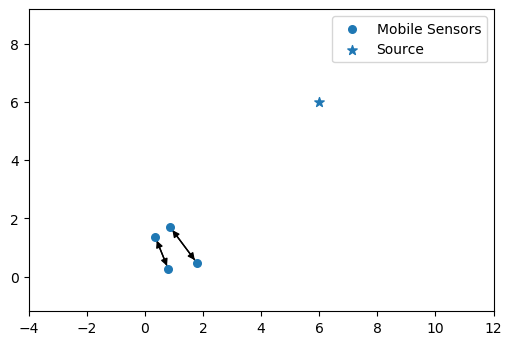

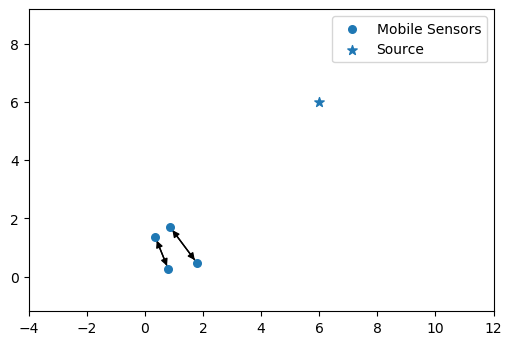

In [52]:
ps = np.array([locs for sensor, locs in record['sensor_locs'].items()])
qs = record['src_locs']['source_1']
N_iter = ps.shape[1]

fig, ax = plt.subplots(dpi=100)
def plot_single_frame(j):
    ax.cla()
    G = record['comm_network'][j]
    nx.draw(G,pos=ps[:,j,:],ax=ax,label='Mobile Sensors',node_size=30) # ps.shape=(n_sensors,N_iter,space_dim)
    ax.scatter(qs[j,0],qs[j,1],marker='*',s=50,label='Source')
    ax.axis('on')
    ax.axis('equal')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim((-4,12))
    ax.set_ylim((-4,12))
    ax.legend()
    plt.show()
    

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, plot_single_frame,
                               frames=N_iter,interval=500)


In [53]:
HTML(anim.to_html5_video())